# IBIS-AMI Model Tester

Original author: David Banas <capn.freako@gmail.com>  
Original date:   February 8, 2025

Copyright &copy; 2025 David Banas, Inc.; all rights reserved World wide.

## Introduction

This [Jupyter](https://jupyter.org) notebook may be used to test any IBIS-AMI model for certain common pathologies.
This notebook can also serve as the final report back to the model maker, by following one of two procedures:

1. Run this notebook manually and export it to HTML format.

    - `File` => `Save and Export Notebook As` => `HTML`

5. Execute the new `run-notebook` command, which was recently added to the [_PyIBIS-AMI_](https://pyibis-ami.readthedocs.io/en/latest/index.html) Python package.

    - You may need to execute: `pip install --upgrade PyIBIS-AMI`, to make this command available.
    - Try `run-notebook -h` for usage and help.

**Note:** This notebook was originally created, by copying a very similar notebook: `IBIS_AMI_Checker.ipynb`.
That notebook is intended for more hands-on, interactive use (during initial model debugging, for instance), whereas this notebook is intended to support the new `run-notebook` command, by running in a stand-alone fashion with no user interaction necessary.

**Note:** If you are viewing an HTML file generated by the new `run-notebook` command then you will not see any of the Python code referred to in some of the sections below.
This is intentional.
The `run-notebook` command strips all code from its final report, for brevity.

## Imports and Utilities

Here, we import what we need from the Python Universe and write a few general purpose utility functions used throughout the remainder of this notebook.

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from ctypes               import CDLL, byref, c_char_p, c_double
from os                   import environ
from os.path              import dirname, join, splitext
from pathlib              import Path
from random               import randrange
from typing               import Any, Generator

from numpy                import (abs, arange, array, concatenate, convolve, cos, cumsum,
                                  diff, exp, log10, linspace, logspace, ones, pad, pi,
                                  roll, unwrap, zeros)
from numpy.fft            import fft, fftshift, irfft, rfft
from numpy.random         import default_rng
from numpy.typing         import NDArray
from scipy.interpolate    import interp1d
from scipy.signal         import butter, freqs, lfilter

from pyibisami.ami.model  import AMIModel, AMIModelInitializer
from pyibisami.ami.parser import AMIParamConfigurator
from pyibisami.ibis.file  import IBISModel
from pyibisami.tools.run_tests import color_picker, expand_params


# def get_init(
#     pcfg:             AMIParamConfigurator,
#     bit_time:         float,
#     row_size:         int,
#     sample_interval:  float,
#     channel_response: NDArray[float]
# ) -> AMIModelInitializer:
#     """
#     Get a model initializer, configured by the user.
#     """
#     pcfg()  # This call will invoke a GUI applet for the user to interact with,
#             # to configure the AMI parameter values.
#     initializer = AMIModelInitializer(
#         pcfg.input_ami_params,
#         info_params = pcfg.info_ami_params,
#         bit_time = c_double(bit_time),
#         row_size = row_size,
#         sample_interval = c_double(sample_interval)
#     )
#     # Don't try to pack this into the parentheses above!
#     initializer.channel_response = channel_response
#     return initializer

def get_init_resps(model: AMIModel, nspui: int) -> tuple:
    """
    Get the step, pulse, and frequency responses of an initialized model,
    from its `AMI_Init()` function.

    Args:
        model: The initialized model.
        nspui: Number of signal vector samples per unit interval
            (a.k.a. - oversampling factor).

    Returns:
        (t, s, p, f, H): A tuple consisting of:
            t: The time vector indexing `s` and `p`.
            s: The model+channel step response.
            p: The model+channel pulse response.
            f: The frequency vector indexing `H`.
            H: The (complex) model+channel frequency response.

    Notes:
        1. The returned responses include the combined effects of both
            the model and the channel used to initialize it.
    """
    n_shift = len(model.initOut) // 4
    T = model.sample_interval
    h = roll(model.initOut, n_shift)
    len_h = len(h)
    t = array([i * T for i in range(-n_shift, len_h - n_shift)])
    s = cumsum(h) * T  # Step response.
    p = s - pad(s[:-nspui], (nspui, 0), mode='constant', constant_values=0)
    f = array([i * 1.0 / (T * len_h) for i in range(len_h // 2)])
    H = fft(model.initOut)
    H *= s[-1] / abs(H[0])  # Normalize for proper d.c.
    return (t, s, p, f, H)

def get_wave_resps(
    model:         AMIModel,
    nspui:         int,
    ignore_bits:   int = 0,
    bits_per_call: int = 128
) -> tuple:
    """
    Get the step, pulse, and frequency responses of an initialized model,
    from its `AMI_GetWave()` function.

    Args:
        model: The initialized model.
        nspui: Number of signal vector samples per unit interval
            (a.k.a. - oversampling factor).

    Keyword Args:
        ignore_bits: Number of bits to ignore, before paying attention to output.
            (Allows DFE to finish adapting.)
            Default: 0
        bits_per_call: Number of bits to include in each separate call of `AMI_GetWave()`.
            Default: 128

    Returns:
        (t, s, p, f, H): A tuple consisting of:
            t: The time vector indexing `s` and `p`.
            s: The model+channel step response.
            p: The model+channel pulse response.
            f: The frequency vector indexing `H`.
            H: The (complex) model+channel frequency response.

    Notes:
        1. The returned responses include the combined effects of both
            the model and the channel used to initialize it.
    """
    len_h = len(model.initOut)
    n_shift = len_h // 4
    T = model.sample_interval
    t = array([i * T for i in range(-n_shift, len_h - n_shift)])
    f = array([i * 1.0 / (T * len_h) for i in range(len_h // 2)])
    rng = default_rng()
    u = concatenate((rng.integers(low=0, high=2, size=ignore_bits), array([0]*(nbits // 4) + [1]*nbits))).repeat(nspui) - 0.5
    wave_in = convolve(u, array(model.channel_response) * model.sample_interval)
    wave_out, clks_out, params_out = model.getWave(wave_in, bits_per_call=bits_per_call)
    s = wave_out[(ignore_bits + 0) * nspui :] + 0.5
    s -= s[n_shift-1]  # Match the d.c. offset of Init() output, for easier comparison of Init() & GetWave() outputs.
    p = s - pad(s[:-nspui], (nspui, 0), mode='constant', constant_values=0)
    h = diff(s[n_shift-1:])[:len(t)]
    H = fft(h)
    return (t, s[:len(t)], p[:len(t)], f, H)

def plot_resps(fig, t, s, p, f, H, lbl, clrs, s2=None, p2=None, H2=None):
    """
    Plot one or two sets of responses.
    """
    plt.figure(fig)

    rgb_main, _ = clrs
    clr = "#%02X%02X%02X" % (int(rgb_main[0] * 0xFF), int(rgb_main[1] * 0xFF), int(rgb_main[2] * 0xFF))

    plt.subplot(131)
    plt.plot(t*1e9, s, label=lbl, color=clr)
    if s2 is not None:
        plt.plot(t*1e9, s2, linestyle='dashed', color=clr)
    
    plt.subplot(132)
    plt.plot(t*1e9, p, label=lbl, color=clr)
    if p2 is not None:
        plt.plot(t*1e9, p2, linestyle='dashed', color=clr)
    
    plt.subplot(133)
    plt.semilogx(f / 1e9, 20 * log10(abs(H[:len(f)])), label=lbl, color=clr)
    if H2 is not None:
        plt.semilogx(f / 1e9, 20 * log10(abs(H2[:len(f)])), linestyle='dashed', color=clr)

def raised_cosine(x):
    """
    Apply raised cosine filter to input.
    """
    phi = linspace(0, pi, len(x))
    return x * 0.5 * (cos(phi) + 1)


## Model Identification and Definition

Here, we identify the model we wish to check and define its AMI parameters, for further testing.

In [2]:
# This cell should have the `parameters` tag selected.
# Change these.
ibis_file  = "../../../../ibisami/example/example_rx.ibs"  # Change this to the IBIS-AMI model you want to test.
is_tx = False        # True for Tx; False for Rx.
debug = False        # Set to 'True' if you're having trouble and need some debugging info.
bit_rate = 10e9
nspui = 32           # vector samples per unit interval
nbits = 200          # number of bits for AMI_Init() exercising
plot_t_max = 0.5e-9  # maximum x-axis extent for time domain plots (s)
f_max = 40e9         # maximum frequency (Hz)
f_step = 10e6        # frequency step (Hz)
fig_x = 10           # Figures x-dimmension (in.)
fig_y = 3            # Figures y-dimmension (in.)
params = []          # AMI parameter overrides


In [4]:
# Don't change these.
fs = bit_rate * nspui
sample_interval = 1 / (fs)
row_size = nbits * nspui
bit_time = 1 / bit_rate
t = array([n * sample_interval for n in range(row_size)])
f = arange(0, f_max + f_step, f_step)
w = 2 * pi * f
ts = 0.5 / f_max
t_fft = array([n * ts for n in range(2 * (len(f) - 1))])

## Model Importing and Sanity Checking

Here, we just attempt to import the model and do some basic sanity checking on it.

In [5]:
success = True

# Import the *.ibs file.
try:
    ibis = IBISModel(ibis_file, is_tx, debug=debug, gui=False)
    dName = dirname(ibis_file)
    assert ibis.dll_file and ibis.ami_file, RuntimeError(
        "Missing AMI file and/or DLL file definition(s) in IBIS file!"
    )
    dll_file = join(dName, ibis.dll_file)
    ami_file = join(dName, ibis.ami_file)
except Exception as err:
    success = False
    raise RuntimeError(f"Failed to open/import IBIS file!\n{err}")

# Import the *.dll/so file.
try:
    model = AMIModel(str(dll_file))
except Exception as err:
    success = False
    raise RuntimeError(f"Failed to open/import DLL/SO file!\n{err}")

# Import the *.ami file.
try:
    with open(ami_file, mode="r", encoding="utf-8") as pfile:
        pcfg = AMIParamConfigurator(pfile.read())
    if pcfg.ami_parsing_errors:
        print(f"Non-fatal parsing errors:\n{pcfg.ami_parsing_errors}")
    has_getwave = pcfg.fetch_param_val(["Reserved_Parameters", "GetWave_Exists"]) or False
    ignore_bits = pcfg.fetch_param_val(["Reserved_Parameters", "Ignore_Bits"]) or 0
    returns_impulse = pcfg.fetch_param_val(["Reserved_Parameters", "Init_Returns_Impulse"]) or False
    if pcfg.fetch_param_val(["Reserved_Parameters", "Ts4file"]):
        has_ts4 = True
    else:
        has_ts4 = False
except Exception as err:
    success = False
    raise RuntimeError(f"Failed to open/import AMI file!\n{err}")

# Summarize results.
if success:
    print("Model import was successful.")
else:
    print("Model import failed!")
if has_getwave:
    print("Model has a `AMI_GetWave()` function.")
    print(f"\tThe first {ignore_bits} returned bits should be ignored.")
else:
    print("Model has no `AMI_GetWave()` function.")
if returns_impulse:
    print("Model's `AMI_Init()` function returns an impulse response.")
else:
    print("Model's `AMI_Init()` function does not return an impulse response.")
if has_ts4:
    print("Model includes on-die S-parameters.")
else:
    print("Model does not include on-die S-parameters.")


Model import was successful.
Model has a `AMI_GetWave()` function.
	The first 0 returned bits should be ignored.
Model's `AMI_Init()` function returns an impulse response.
Model does not include on-die S-parameters.


## Perfect Channel (Model Response)

Here, we represent the "channel" by a Kronecker delta function, so as to elicit the actual responses of the model itself.  
This imposes certain limitations on our testing.
For instance, since any equalization is over-equalization for such a perfect "channel", if the model imposes:

- a minimum amount of CTLE peaking, or
- a minimum first DFE tap value,
- etc.,

then we will end up in an over-equalized state.  
Such a state will not usually affect the `AMI_Init()` function, but may affect the `AMI_GetWave()` function, particularly if a DFE has been enabled.  
And this will cause disagreement between the two.
Therefore:

**The results of this section should be considered with some skepticism, as far as inferring how the model will behave in a "real World" scenario.**

The _Lossy Channel_ and _Reflective Channel_ sections, below, give a more useful assessment of the model's behavior in such real use scenarios.


In [6]:
# Globals
channel_response = array([1.0] + [0. for n in range(row_size - 1)]) / sample_interval  # Dirac delta


### Init() vs. GetWave()

Here, we check to see that the fundamental responses of the model are the same whether we call `AMI_Init()` or `AMI_GetWave()`.

**Note:** This test is only possible for models that:

1. have a `AMI_GetWave()` function, and
2. return an impulse response from their `AMI_Init()` function.

**Note:** When you run the following cell it will bring a GUI applet to life, which is intended to be used by you to configure the model's AMI parameters in a way that makes sense for this test.
However, the applet may not receive focus automatically.
And you may need to invoke it from your task bar.

Running sweep `rate`: Sweep of bit rate values.



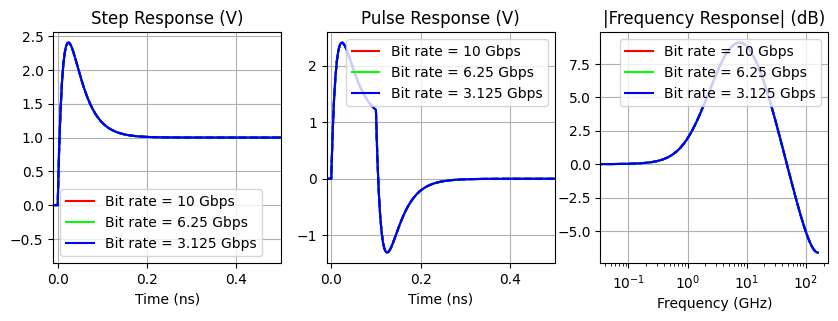

Running sweep `ctle`: Sweep of Rx CTLE filter values.



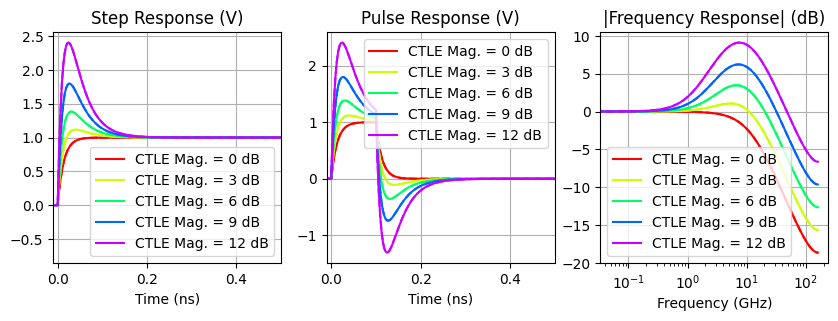

RuntimeError: Debugging stop.

In [7]:
RGB = tuple[float, float, float]

def init_vs_getwave(
    cfg_name: str,
    description: str,
    param_list: list[tuple[str, tuple[dict[str, Any], dict[str, Any]]]],
    colors: Generator[tuple[RGB, RGB], None, None]
) -> None:
    """
    Run the `AMI_Init()` vs. `AMI_GetWave()` comparison,
    for a particular AMI parameter sweep program.

    Args:
        cfg_name: Name of this AMI parameter configuration sweep.
        description: Description of this AMI parameter configuration sweep.
        param_list: List of AMI parameter sets to use for sweep.
        colors: Plot colors to use.
    """
    print(f"Running sweep `{cfg_name}`: {description}")
    fig = plt.figure(figsize=(fig_x, fig_y))
    for color, (label, (ami_params, sim_params)) in zip(colors, param_list):
        model.initialize(pcfg.get_init(
            bit_time, row_size, sample_interval, channel_response, ami_params))
        t, s,  p,  f, H  = get_init_resps(model, nspui)
        _, s2, p2, _, H2 = get_wave_resps(model, nspui, ignore_bits=ignore_bits)
        plot_resps(fig, t, s, p, f, H, label, color, s2=s2, p2=p2, H2=H2)
    plt.subplot(131)
    plt.axis(xmin=-0.01, xmax=plot_t_max*1e9)
    plt.title("Step Response (V)")
    plt.xlabel("Time (ns)")
    plt.grid()
    plt.legend()
    plt.subplot(132)
    plt.axis(xmin=-0.01, xmax=plot_t_max*1e9)
    plt.title("Pulse Response (V)")
    plt.xlabel("Time (ns)")
    plt.grid()
    plt.legend()
    plt.subplot(133)
    plt.title("|Frequency Response| (dB)")
    plt.xlabel("Frequency (GHz)")
    plt.grid()
    plt.legend()
    plt.show()

# initializer = get_init(pcfg, bit_time, row_size, sample_interval, channel_response)
for cfg_item in params:
    cfg_name    = cfg_item[0]
    description = cfg_item[1]
    param_list  = cfg_item[2]
    colors      = color_picker(num_hues=len(param_list))
    init_vs_getwave(cfg_name, description, param_list, colors)

# raise RuntimeError(f"Debugging stop.\nparam_list: {param_list}")
raise RuntimeError("Debugging stop.")


Compare the plots above.
The _Init()_ (solid) and _GetWave()_ (dashed) plots should look nearly identical.  
(**Note:** Ignore the waveform before time zero; it's not expected to match and is plotted only as a debugging aid.)

**Note:** If you've enabled an adaptive DFE in an Rx model then the plots may look different, because:

1. The "channel" is perfect here, which means that _any_ equalization (a minimum amount of CTLE peaking or minimum first DFE tap value, for instance) is _over_-equalization, and

2. The AMI parameter controlling the "target" voltage at the slicer input may have a maximum of 1.0V, which is too low in the case of an over-equalized channel.

    - The `AMI_Init()` function will _not_ be affected by this, while the `AMI_GetWave()` function _will_.
  
You should see better agreement between the `AMI_Init()` and `AMI_GetWave()` outputs, when this test is repeated below for a _Lossy_ channel.

### Samples per Bit

Here, we test the model's sensitivity to the oversampling factor, i.e., number of samples per bit (or, symbol).

In [ ]:
def samples_per_bit():
    """Run the "Samples per Bit" comparison."""
    krnl = interp1d(
        t, channel_response, kind="cubic",
        bounds_error=False, fill_value="extrapolate", assume_sorted=True
    )  # interpolation "kernel"

    # Do not interpolate deltas.
    len_ch_resp = len(channel_response)
    def interp(x):
        if not any(channel_response[1:]):  # delta?
            len_x = len(x)
            if len_x > len_ch_resp:
                rslt = pad(channel_response, (0, len_x - len_ch_resp),
                           mode="constant", constant_values=0)
            else:
                rslt = channel_response[:len_x]
            return rslt * sample_interval / _sample_interval
        else:
            return krnl(x)

    fig = plt.figure(figsize=(fig_x, fig_y))
    for osf in [nspui//2, nspui, nspui*2]:
        _sample_interval = 1 / (bit_rate * osf)
        _row_size = nbits * osf
        _t = array([n * _sample_interval for n in range(_row_size)])
        initializer.sample_interval = _sample_interval
        initializer.row_size = _row_size
        initializer.channel_response = interp(_t)
        model.initialize(initializer)
        _t, _s, _p, _f, _H = get_init_resps(model, osf)
        plot_resps(fig, _t, _s, _p, _f, _H, [f"{osf}x"])    
    plt.subplot(131)
    plt.axis(xmin=-0.01, xmax=plot_t_max*1e9)
    plt.subplot(132)
    plt.axis(xmin=-0.01, xmax=plot_t_max*1e9)
    plt.show()

samples_per_bit()


You should see very little difference between the 3 plots in any of the charts above.

### Linearity Check

Here, we check that the `AMI_Init()` function is linear.

**Note:** There is no requirement that the `AMI_GetWave()` function exhibit linearity.
In fact, the `AMI_GetWave()` function is often used to capture _non_-linear behavior.

In [ ]:
# Generate several different channel impulse responses.
tmax = sample_interval * row_size
t_gauss = array([-tmax / 2 + n * sample_interval for n in range(row_size)])
f0_gauss = 1 / tmax
f_gauss = array([f0_gauss * n for n in range(row_size // 2 + 1)])
hs = []
print("Channel Responses:")
fig = plt.figure(figsize=(fig_x, fig_y))
for bw in array([0.8, 0.9, 1.0, 1.1, 1.2]) * bit_rate:
    # exp(-t20 
    h_gauss = exp(-((4.5 * bw * t_gauss) ** 2))
    h_gauss /= h_gauss.sum()
    s_gauss = cumsum(h_gauss)
    p_gauss = s_gauss - pad(s_gauss[:-nspui], (nspui, 0), mode="constant", constant_values=0)
    H_gauss = rfft(h_gauss)
    lbl = f"{bw / 1e9 : 6.2f}"
    plot_resps(fig, t_gauss, s_gauss, p_gauss, f_gauss, H_gauss, [lbl])    
    hs.append((h_gauss, lbl))
plt.subplot(131)
plt.axis(xmin=-plot_t_max / 2 * 1e9, xmax=plot_t_max / 2 * 1e9)
plt.subplot(132)
plt.axis(xmin=-plot_t_max / 2 * 1e9, xmax=plot_t_max / 2 * 1e9)
plt.subplot(133)
plt.axis(xmin=1, xmax=f_max / 1e9, ymin=-40, ymax=0)
plt.show()

def check_linearity(hs):
    """
    Compare sum of model's responses to model's response to sum.

    Args:
        hs: List of channel impulse responses to use.
    """
    print("Model Responses:")
    h_shift = int(-0.49 * row_size)
    hs_sum = sum(map(lambda h: h[0], hs)) / len(hs)
    initializer.sample_interval = sample_interval
    initializer.row_size = row_size
    initializer.channel_response = roll(hs_sum, h_shift) / sample_interval
    model.initialize(initializer)
    t_sum, s_sum, p_sum, f_sum, H_sum = get_init_resps(model, nspui)
    s_tot = zeros(row_size)
    p_tot = zeros(row_size)
    H_tot = zeros(row_size) * 1j
    for h in hs:
        initializer.channel_response = roll(h[0], h_shift) / sample_interval
        model.initialize(initializer)
        _, _s, _p, _, _H = get_init_resps(model, nspui)
        s_tot += _s
        p_tot += _p
        H_tot += _H
    s_tot /= len(hs)
    p_tot /= len(hs)
    H_tot /= len(hs)
    fig = plt.figure(figsize=(fig_x, fig_y))
    plot_resps(fig, t_sum, s_sum, p_sum, f_sum, H_sum, ["Response to Sum"])    
    plot_resps(fig, t_sum, s_tot, p_tot, f_sum, H_tot, ["Sum of Responses"])    
    plt.subplot(131)
    plt.axis(xmin=-0.01, xmax=plot_t_max * 1e9)
    plt.subplot(132)
    plt.axis(xmin=-0.01, xmax=plot_t_max * 1e9)
    plt.subplot(133)
    plt.axis(xmin=1, xmax=f_max / 1e9)
    plt.show()

check_linearity(hs)


If the `AMI_Init()` function of your model is truly linear then you should see very little difference between the pair of traces in any of the 3 plots in the second row above.

### `AMI_GetWave()` Input Length Sensitivity

Sometimes, depending upon how it's implemented, the `AMI_GetWave()` function may exhibit sensitivity to the length of its input.
And this is undesireable.  
Here, we try to flush that out if it's occurring.

In [ ]:
def check_getwave_input_length():
    """
    Check sensitivity of `AMI_GetWave()` to varying input length,
    for the given channel impulse response.
    """
    u = (array([randrange(2) for n in range(1_000)]) * 2 - 1).repeat(nspui)
    len_u = len(u)
    t = array([n * sample_interval for n in range(len_u)])
    f0 = 1 / (sample_interval * len_u)
    f = array([n * f0 for n in range(len_u)])
    plt.figure(figsize=(fig_x, fig_y))
    initializer.sample_interval = sample_interval
    initializer.row_size = row_size
    initializer.channel_response = channel_response
    model.initialize(initializer)
    for n, bits_per_call in enumerate([randrange(8, 512) for n in range(5)] + [511, 513]):
        input_len = bits_per_call * nspui
        smpl_cnt = 0
        ys = array([])
        while smpl_cnt < len_u:
            if smpl_cnt + input_len > len_u:
                x = u[smpl_cnt :]
            else:
                x = u[smpl_cnt : smpl_cnt + input_len]
            y, _, _ = model.getWave(x)
            ys = concatenate((ys, y))
            smpl_cnt += input_len
        if n:
            plt.subplot(121)
            plt.plot(t * 1e9, ys, label=str(bits_per_call))
            plt.subplot(122)
            Ys = fft(ys)
            plt.semilogx(f[:len_u // 2] / 1e9, 20 * log10(abs(Ys[:len_u // 2])),
                         label=str(bits_per_call))
    
    plt.subplot(121)
    plt.title("AMI_GetWave() Output")
    plt.xlabel("Time (ns)")
    plt.ylabel("Vout (V)")
    plt.legend()
    plt.grid()
    
    plt.subplot(122)
    plt.title("Spectral Content")
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("|H(f)| (dB)")
    plt.legend()
    plt.grid()
    
    plt.show()

check_getwave_input_length()


You should see very little difference in either domain between the various plots in either chart above.

**Note:** You may want to re-run the cell above several times, in order to test additional, randomly selected input lengths.

## Lossy Channel

Here, we test the model against a well terminated, but very lossy, channel.


In [ ]:
fN = (bit_rate / 2)  # "Nyquist"
fc = fN / 10         # cut-off
b, a = butter(1, 2 * pi * fc, analog=True)
_, H = freqs(b, a, worN=w)
plt.figure(figsize=(fig_x, fig_y))
plt.semilogx(f / 1e9, 20 * log10(abs(H)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
# plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(fN / 1e9, color='green')
plt.axis(xmin=fN/100/1e9, xmax=f_max/1e9)
plt.show()


In [ ]:
b, a = butter(1, fc, fs=fs)
channel_response = lfilter(b, a, array([0.0, 1.0] + [0. for n in range(row_size - 2)])) / sample_interval
plt.figure(figsize=(fig_x, fig_y))
plt.plot(t * 1e9, channel_response / 1e9)
plt.title("Lossy Channel Impulse Response")
plt.xlabel("Time (ns)")
plt.ylabel("h(t) (V/ns)")
plt.show()


### Init() vs. GetWave()

Here, we check to see that the fundamental responses of the model are the same whether we call `AMI_Init()` or `AMI_GetWave()`.

**Note:** This test is only possible for models that:

1. have a `AMI_GetWave()` function, and
2. return an impulse response from their `AMI_Init()` function.

**Note:** When you run the following cell it will bring a GUI applet to life, which is intended to be used by you to configure the model's AMI parameters in a way that makes sense for this test.
However, the applet may not receive focus automatically.
And you may need to invoke it from your task bar.

In [ ]:
initializer = get_init(pcfg, bit_time, row_size, sample_interval, channel_response)

init_vs_getwave(initializer)


### Samples per Bit

Here, we test the model's sensitivity to the oversampling factor, i.e., number of samples per bit (or, symbol).

In [ ]:
samples_per_bit()


### `AMI_GetWave()` Input Length Sensitivity

Sometimes, depending upon how it's implemented, the `AMI_GetWave()` function may exhibit sensitivity to the length of its input.  
And this is undesireable.  
Here, we try to flush that out if it's occurring.

In [ ]:
check_getwave_input_length()


## Reflective Channel

Here, we test the model against a poorly terminated, very reflective channel.


In [ ]:
fc = fN  # cut-off
b, a = butter(1, 2 * pi * fc, analog=True)
# _, H = freqs(b, a, worN=(2 * pi * f))
_, H = freqs(b, a, worN=w)
td = 100e-12  # one-way channel delay
r = 0.2    # reflection coefficient
H *= (1 - r) * exp(-1j * w * td) / (1 - r * exp(-2j * w * td))
h = irfft(raised_cosine(H)) / ts
krnl = interp1d(t_fft, h)
channel_response = krnl(t)

plt.figure(figsize=(fig_x, fig_y))

plt.subplot(121)
plt.plot(t_fft * 1e9, h * 1e-9, label="orig")
plt.plot(t * 1e9, channel_response * 1e-9, label="interp")
plt.title('Channel Impulse Response')
plt.xlabel('Time (ns)')
plt.ylabel('h(t) (V/ns)')
plt.axis(xmin=0, xmax=1)
plt.legend()

plt.subplot(122)
plt.semilogx(f / 1e9, 20 * log10(abs(H)), label="raw")
plt.semilogx(f / 1e9, 20 * log10(abs(raised_cosine(H))), label="win")
plt.title('Reflective Channel Frequency Response')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Magnitude (dB)')
# plt.margins(0, 0.1)
plt.axis(xmin=1e-1, xmax=1e2, ymin=-40, ymax=1)
plt.grid(which='both', axis='both')
plt.legend()

plt.show()


### Init() vs. GetWave()

Here, we check to see that the fundamental responses of the model are the same whether we call `AMI_Init()` or `AMI_GetWave()`.

**Note:** This test is only possible for models that:

1. have a `AMI_GetWave()` function, and
2. return an impulse response from their `AMI_Init()` function.

**Note:** When you run the following cell it will bring a GUI applet to life, which is intended to be used by you to configure the model's AMI parameters in a way that makes sense for this test.
However, the applet may not receive focus automatically.
And you may need to invoke it from your task bar.


In [ ]:
initializer = get_init(pcfg, bit_time, row_size, sample_interval, channel_response)

init_vs_getwave(initializer)


### Samples per Bit

Here, we test the model's sensitivity to the oversampling factor, i.e., number of samples per bit (or, symbol).

In [ ]:
samples_per_bit()


### `AMI_GetWave()` Input Length Sensitivity

Sometimes, depending upon how it's implemented, the `AMI_GetWave()` function may exhibit sensitivity to the length of its input.  
And this is undesireable.  
Here, we try to flush that out if it's occurring.

In [ ]:
check_getwave_input_length()
